<a href="https://colab.research.google.com/github/yedini/DL_tensorflow/blob/main/Part3_Lab04_MNIST_cnn_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### How to get the BEST performance?
- data augmentation
- batch normalization
- model ensemble
- learning rate decay

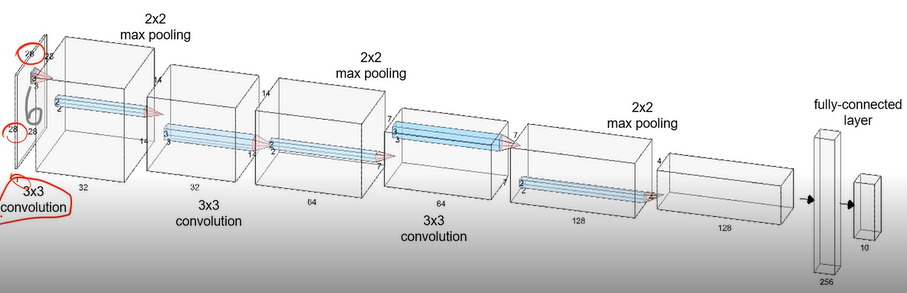

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import ndimage

print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


In [ ]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

tf.random.set_seed(777)

cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'minst_cnn_best'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

In [ ]:
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#### Data Augmentation
- rotation & shift

In [ ]:
def data_augmentation(images, labels):
    aug_images = []
    aug_labels = []    
    
    for x, y in zip(images, labels):        
        aug_images.append(x)
        aug_labels.append(y)        
        
        bg_value = np.median(x)  #rotation이나 shift한 후 이미지의 빈공간을 채우기 위해
        
        for _ in range(4):   # 데이터를 4배만큼 늘린다
            angle = np.random.randint(-15, 15, 1)     #-15, 15 사이에서 random하게 숫자 1개 뽑음      
            rot_img = ndimage.rotate(x, angle[0], reshape=False, cval=bg_value) #위 angle만큼 rotation, 빈공간은 bg_value로 채우기
            
            shift = np.random.randint(-2, 2, 2)  #세로방향, 가로방향 하나씩 뽑기
            shift_img = ndimage.shift(rot_img, shift, cval=bg_value)            
            
            aug_images.append(shift_img)
            aug_labels.append(y)
    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels)
    return aug_images, aug_labels

In [ ]:
# data pipelining
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images, train_labels = data_augmentation(train_images, train_labels) #augmentation 적용
    
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=500000).batch(batch_size)  # buffer_size를 키워줌.
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


Neural Network model 만들기

In [ ]:
class ConvBNRelu(tf.keras.Model):  # 작은 네트워크 만들기
    def __init__(self, filters, kernel_size=3, strides=1, padding='SAME'):
        super(ConvBNRelu, self).__init__()  #상위 클래스 init
        self.conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                                        padding=padding, kernel_initializer='glorot_normal')
        self.batchnorm = tf.keras.layers.BatchNormalization()
    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        return layer

In [ ]:
class DenseBNRelu(tf.keras.Model):
    def __init__(self, units):
        super(DenseBNRelu, self).__init__()
        self.dense = keras.layers.Dense(units=units, kernel_initializer='glorot_normal')
        self.batchnorm = tf.keras.layers.BatchNormalization()
    def call(self, inputs, training=False):
        layer = self.dense(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        return layer

In [ ]:
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = ConvBNRelu(filters=32, kernel_size=[3, 3], padding='SAME')        
        self.pool1 = keras.layers.MaxPool2D(padding='SAME')
        self.conv2 = ConvBNRelu(filters=64, kernel_size=[3, 3], padding='SAME')
        self.pool2 = keras.layers.MaxPool2D(padding='SAME')
        self.conv3 = ConvBNRelu(filters=128, kernel_size=[3, 3], padding='SAME')
        self.pool3 = keras.layers.MaxPool2D(padding='SAME')
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = DenseBNRelu(units=256)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=10, kernel_initializer='glorot_normal')
    def call(self, inputs, training=False):
        net = self.conv1(inputs)        
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

In [ ]:
models = []
num_models = 5   #ensemble
for m in range(num_models):
    models.append(MNISTModel())

In [ ]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))    
    return loss

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.trainable_variables)

In [ ]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
                                                          train_images.shape[0]/batch_size*num_models*5, # => 5 epoch
                                                          0.5, staircase=True) # 5 epoch을 지나면 learning_rate를 0.5배로 줄여라
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)

In [ ]:
checkpoints = []
for m in range(num_models):
    checkpoints.append(tf.train.Checkpoint(cnn=models[m]))

In [ ]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0        
    for images, labels in train_dataset:
        for model in models:
            grads = grad(model, images, labels)                
            optimizer.apply_gradients(zip(grads, model.trainable_variables))            
            loss = loss_fn(model, images, labels)
            avg_loss += loss / num_models
        acc = evaluate(models, images, labels)
        avg_train_acc += acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(models, images, labels)        
        avg_test_acc += acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))
    
    
    for idx, checkpoint in enumerate(checkpoints):
        checkpoint.save(file_prefix=checkpoint_prefix+'-{}'.format(idx))

print('Learning Finished!')